In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [12]:
def compute_sensitivity(xs, ys, eps, delta):
    
    # Create a new model
    m = gp.Model("bilinear")
    m.setParam('OutputFlag', 0)
    m.Params.TimeLimit = 10
    # Create variables                

    beta1 = m.addVar(name="beta1")
    beta2 = m.addVar(name="beta2")
    d_x1 = m.addVar(name="dx1")
    d_x2 = m.addVar(name="dx2")
    d_xy1 = m.addVar(name="dxy1")
    d_xy2 = m.addVar(name="dxy2")
    diff = m.addVar(name="diff")

    # Set objective: maximize x
    m.setObjective(diff, GRB.MAXIMIZE)

    m.addConstr(beta1 - beta2 - diff == 0)
    
    sum_x_sq = np.sum(np.square(xs))
    sum_xy = np.sum(xs * ys)

    # Add bilinear optimality constraints
    m.addConstr(beta1 * (sum_x_sq + d_x1) - sum_xy - d_xy1 == 0, "beta1_opt_c")
    m.addConstr(beta2 * (sum_x_sq + d_x1 + d_x2) - sum_xy - d_xy1 - d_xy2 == 0, "beta2_opt_c")

    # Add linear perturbation constraints
    num = int(np.ceil(np.log(1/delta) / eps))
    
    Z = [m.addVar(lb=-1, ub=1, vtype=GRB.INTEGER, name="z" + str(i)) for i in range(num + 1)]
    
#     Z = [m.addVar(name="z" + str(i), vtype=GRB.CONTINUOUS) for i in range(num + 1)]
    
#     for i in range(num + 1):
#         m.addConstr(-1 <= Z[i])
#         m.addConstr(Z[i] <= 1)

    points = m.addMVar((num + 1, 2), name="points")

    # d1 definition
    m.addConstr(d_x1 == sum([Z[i] * points[i,0] for i in range(num)]), "dx1_def")
    m.addConstr(d_xy1 == sum([Z[i] * points[i,1] for i in range(num)]), "dxy1_def")

    # d2 definition
    m.addConstr(d_x2 == Z[num] * points[num, 0], "dx2_def")
    m.addConstr(d_xy2 == Z[num] * points[num, 1], "dxy2_def")

    # hull constraints
    hull = ConvexHull(np.array([np.square(xs), xs * ys]).T)
    M = hull.equations
    A =  -1 * np.array(M[:, :-1], dtype=float)
    b = np.array(M[:, -1], dtype=float)

    for i in range(num + 1):
        m.addConstr(A @ points[i] >= b)

    # Solve bilinear model
    m.Params.NonConvex = 2
        
    m.optimize()
    
    b1, v1 = m.ObjBound, m.ObjVal
    
    m.setObjective(-1 * diff, GRB.MAXIMIZE)
    
    m.optimize()
    
    b2, v2 = m.ObjBound, m.ObjVal
    # print(b1,v1,b2,v2)
    return max(v1, v2), max(b1, b2)

In [9]:
delta = 1e-32
eps = 10
n =50
slope = 100000
# x = np.random.randn(n)
x = np.sign(np.random.randn(n)) + .0001 * np.random.randn(n)
y = x * slope + np.random.randn(n) 

v, b = compute_sensitivity(x,y,eps,delta)

In [10]:
np.min(x*y),np.max(x*y), b

(99944.31921247332, 100037.05029916075, 0.032759723311755806)

In [ ]:
b

eps: 1, delta: 1e-32
gap : 3585.466091386742
num points : 100
sigma /sqrt(n) : 0.1
sensitivity : 216.20510630236276
sensitivity  / (sigma / sqrt(n)) (OJO): 2162.0510630236276
Bounds  8.71718638405025e-06 3.959141407848477 0.08960898997157077 39594.325886260835



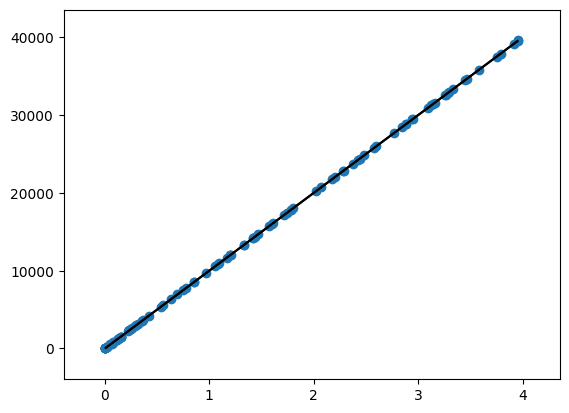

---------------------------------------------------


In [14]:
delta = 1e-32
eps = 1
sigma = 1
slope = 10000

print("eps: {}, delta: {}".format(eps, delta))
for n in [100]:#[50, 100, 500, 1000, 10000]:
    
    xs = np.sign(np.random.randn(n)) +  np.random.rand(n)
    ys = xs * slope + np.random.randn(n) * sigma
    
    xs_sq = np.square(xs)
    xys = xs * ys
    num = np.ceil(np.log(1/delta) / eps)
    val, bound  = compute_sensitivity(xs, ys, eps, delta)

    print("gap :", (bound-val)/ val )
    print("num points :", n) 
    print("sigma /sqrt(n) :", sigma / np.sqrt(n)) 
    print("sensitivity :", bound)
    print("sensitivity  / (sigma / sqrt(n)) (OJO):", np.sqrt(n) *  bound / sigma)
    print("Bounds ", np.min(xs_sq), np.max(xs_sq), np.min(xys), np.max(xys))
    print()
    
    hull = ConvexHull(np.array([np.square(xs), xs * ys]).T)
    convex_hull_plot_2d(hull)
    plt.show()
    print("---------------------------------------------------")

In [ ]:
import statsmodels.api as sm
ols = sm.OLS(ys, xs)
results = ols.fit()
results.summary()

In [ ]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
np.array([np.square(x), x* y]).T



hull = ConvexHull(np.array([np.square(x), x* y]).T)

slope = .5
n = 100000
x = np.random.randn(n)
y = x * slope + np.random.randn(n) 
hull = ConvexHull(np.array([np.square(x), x* y]).T)
plt.scatter(np.square(x), x*y)
convex_hull_plot_2d(hull)

M = hull.equations
A =  -1 * np.array(M[:, :-1], dtype=float)
b = np.array(M[:, -1], dtype=float)
selected = []
not_selected = []
for i in range(1000):
    candidate_point = np.random.randn(2)
    v = (A @ candidate_point) >= b
    truth  = v.all()
    if truth:
        selected.append(candidate_point)
    else:
        not_selected.append(candidate_point)

